In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from  tqdm import tqdm_notebook
import time
from os.path import join
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


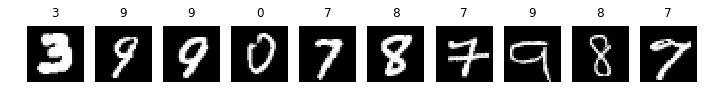

In [2]:
npix = 28

fig = plt.figure(figsize=(12, 4))
P = np.random.permutation(10000)
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    idx = P[i]
    ax.matshow(np.reshape(mnist.train.images[idx, :], (npix, npix)), cmap=plt.cm.Greys_r)
    ax.set_title(str(np.argmax(mnist.train.labels[idx])))
    ax.axis('off')
               

Widget Javascript not detected.  It may not be installed or enabled properly.


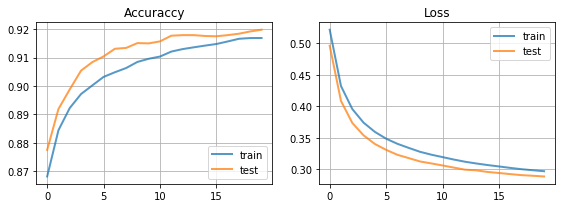

In [3]:
import tensorflow as tf
tf.reset_default_graph()

tf_input = tf.placeholder(tf.float32, [None, 784])
#z = tf.layers.conv2d(inputs=tf.reshape(tf_input, [-1, 28, 28, 1]), 
#                     kernel_size=3, strides=1, filters=10, use_bias=True, activation=tf.nn.relu)
#z = tf.layers.max_pooling2d(inputs=z, pool_size=2, strides=2)
#z = tf.layers.flatten(z)
#z = tf.layers.dense(inputs=z, units=10, use_bias=True, activation=tf.nn.relu)
y = tf.layers.dense(inputs=tf_input, units=10, use_bias=True, activation=tf.nn.softmax)
tf_label = tf.placeholder(tf.float32, [None, 10])
loss = tf.reduce_mean(-tf.reduce_sum(tf_label * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(learning_rate=1e-2).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(tf_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

nepochs = 20
batch_size = 32
metrics_train = np.zeros(shape=(nepochs, 2))
metrics_test = np.zeros(shape=(nepochs, 2))

config = tf.ConfigProto(device_count = {'GPU': 0}) # USE CPU
with tf.Session(config=config) as sess:
    tf.global_variables_initializer().run()
    
    for epoch in tqdm_notebook(range(nepochs), desc='Train epoch'):
        for _ in range(int(mnist.train.images.shape[0]/batch_size)):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            sess.run(train_step, feed_dict={tf_input: batch_xs, tf_label: batch_ys})
        acc_value, loss_value = sess.run([accuracy, loss], 
                                         feed_dict={tf_input: mnist.train.images, 
                                                    tf_label: mnist.train.labels})
        metrics_train[epoch, 0], metrics_train[epoch, 1] = acc_value, loss_value
        acc_value, loss_value = sess.run([accuracy, loss], 
                                         feed_dict={tf_input: mnist.test.images, 
                                                    tf_label: mnist.test.labels})
        metrics_test[epoch, 0], metrics_test[epoch, 1] = acc_value, loss_value

fig = plt.figure(figsize=(8, 3))
for i, text in enumerate(['Accuraccy', 'Loss']):
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title(text)
    ax.plot(metrics_train[:, i], linewidth=2, alpha=0.75, label='train')
    ax.plot(metrics_test[:, i], linewidth=2, alpha=0.75, label='test')
    plt.legend(); plt.grid();
plt.tight_layout()

Widget Javascript not detected.  It may not be installed or enabled properly.


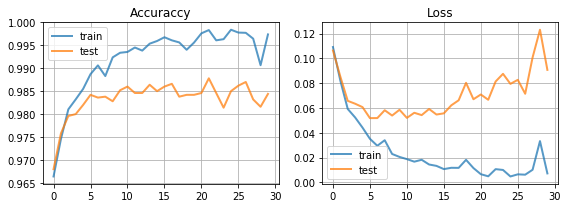

In [4]:
import torch
import torch.nn.functional as F

class conv_net(torch.nn.Module):
    
    def __init__(self, n_conv=8, n_hidden=64):
        super(conv_net, self).__init__()
        #self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=n_conv, kernel_size=3, stride=1, bias=True)
        #self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        #self.conv2 = torch.nn.Conv2d(in_channels=n_conv, out_channels=n_conv, kernel_size=3, stride=1, bias=True)
        #self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=28*28,
                                   out_features=n_hidden, bias=True) #n_conv*5*5
        self.fc2 = torch.nn.Linear(in_features=n_hidden,
                                   out_features=10, bias=True)
        
    def forward(self, x):
        #z = F.relu(self.conv1(x.view(-1, 1, 28, 28)))
        #z = self.pool1(z)
        #z = F.relu(self.conv2(z))
        #z = self.pool2(z)
        #z = z.view(-1, net.fc1.in_features)
        z = F.relu(self.fc1(z))
        z = F.log_softmax(self.fc2(z), dim=1)
        return z

net = conv_net()
nepochs = 30
batch_size = 32
metrics_train = np.zeros(shape=(nepochs, 2))
metrics_test = np.zeros(shape=(nepochs, 2))
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = torch.nn.NLLLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
net.to(device)

for epoch in tqdm_notebook(range(nepochs), desc='Epochs'): 
    for _ in range(int(mnist.train.images.shape[0]/batch_size)):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_ys = np.argmax(batch_ys, axis=1)
        data, target = torch.from_numpy(batch_xs), torch.from_numpy(batch_ys).type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        output = net(data)
        optimizer.zero_grad()        
        loss = criterion(output, target)  
        loss.backward()
        optimizer.step()
    # Train accuracy
    target = np.argmax(mnist.train.labels, axis=1)
    data, target = torch.from_numpy(mnist.train.images), torch.from_numpy(target).type(torch.LongTensor)
    data, target = data.to(device), target.to(device)
    output = net(data)
    _, predicted = torch.max(output.data, dim=1)
    loss_value = criterion(output, target).item()
    acc_value = (predicted == target).sum().item()/len(target)
    metrics_train[epoch, 0], metrics_train[epoch, 1] = acc_value, loss_value
    # Test accuracy
    target = np.argmax(mnist.validation.labels, axis=1)
    data, target = torch.from_numpy(mnist.validation.images), torch.from_numpy(target).type(torch.LongTensor)
    data, target = data.to(device), target.to(device)
    output = net(data)
    _, predicted = torch.max(output.data, dim=1)
    loss_value = criterion(output, target).item()
    acc_value = (predicted == target).sum().item()/len(target)
    metrics_test[epoch, 0], metrics_test[epoch, 1] = acc_value, loss_value
        
fig = plt.figure(figsize=(8, 3))
for i, text in enumerate(['Accuraccy', 'Loss']):
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title(text)
    ax.plot(metrics_train[:, i], linewidth=2, alpha=0.75, label='train')
    ax.plot(metrics_test[:, i], linewidth=2, alpha=0.75, label='test')
    plt.legend(); plt.grid();
plt.tight_layout()